# Getting Started with RAiDER

**Author**: Jeremy Maurer, David Bekaert, Simran Sangha, Yang Lei - Jet Propulsion Laboratory, California Institute of Technology

This notebook provides an overview of how to get started using the RAiDER package for estimating tropospheric RADAR delays, and other functionality included in the **raiderDelay.py** program. We give an example of how to download and process delays using ERA-5 and HRRR weather models for the Los Angeles region. 

In this notebook, we will demonstrate how to:
- Download and install the RAiDER package
- Run RAiDER to generate a grid of delays over the Los Angeles region
    
<div class="alert alert-warning">
The initial setup (<b>Prep A</b> section) should be run at the start of the notebook. The overview sections do not need to be run in order. 
</div>

<div class="alert alert-danger">
<b>Potential Errors:</b> 
    
- GDAL uses "HDF5" driver instead of "netCDF/Network Common Data Format." Verify GDAL version >= 3.
- RAiDER needs to be installed to run this notebook
</div>


<div class="alert alert-info">
    <b>Terminology:</b>
    
- *Acquisition*: A single image acquired by a satellite at a particular time
- *Interferogram*: An unwrapped image containing the surface displacement accumulated between two acquisitions.
- *SLC*: Single-look complex image. A complex single-band raster that contains a single focused RADAR frame from a SAR satellite. For Sentinel-1, SLCs are Level-1 products. 
- *Weather model*: A reanalysis weather product defining temperature, pressure, and humidity on a regular grid in some coordinate system (e.g., at regular lat/lon intervals in the standard EPSG:4326 reference frame).
- *Delay*: The apparent displacement in an interferogram that occurs solely due to changes in weather conditions between two acquisitions.
    </div>
    

## Table of Contents

[**Overview of the raiderDelay.py program**](#overview)  
[1. Details of the user input options](#user-input)  
[- DateList](#date_arg)  
[- Time](#time_arg)  
[- Area of Interest](#aoi_arg)  
[- Line-of-sight information](#los_arg)   
[- Height information](#height_arg)  
[- Weather Model Type](#weather_model_arg)  
[- Other Runtime Parameters](#runtime_arg)
  
[**Example Calculations**](#examples)  
[1. Example using a bounding box](#bounding_box_example)  
[2. Example using a list of GNSS stations](#station_list_example)  

## Prep: Initial setup of the notebook

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Defining the home and data directories
tutorial_home_dir = os.path.abspath(os.getcwd())
work_dir = os.path.abspath(os.getcwd())
print("Tutorial directory: ", tutorial_home_dir)
print("Work directory: ", work_dir)

# Verifying if RAiDER is installed correctly
try:
    import RAiDER
except:
    raise Exception('RAiDER is missing from your PYTHONPATH')

os.chdir(work_dir)

Tutorial directory:  /Users/jeremym/software/RAiDER-docs/notebooks/RAiDER_tutorial
Work directory:  /Users/jeremym/software/RAiDER-docs/notebooks/RAiDER_tutorial


## Overview of the raiderDelay.py program
<a id='overview'></a>

**`raiderDelay.py`** is a command-line program that allows for easy downloading and processing of tropospheric weather delays for InSAR correction or comparison with GNSS tropospheric delays.

We can explore the options by looking at the help menu for the program.

In [1]:
# Running raiderDelay.py -h will print the help menu
!raiderDelay.py -h

usage: raiderDelay.py [-h] --date DATELIST [DATELIST ...] --time TIME
                      (--latlon LAT LONG | --bbox S N W E | --station_file QUERY_AREA)
                      [--lineofsight LOS | --statevectors SV] [--dem DEM]
                      [--heightlvs HEIGHTLVS [HEIGHTLVS ...]]
                      [--model {ERA5,ERA5T,ERAI,MERRA2,WRF,HRRR,GMAO,HDF5,HRES,NCMR}]
                      [--files FILES [FILES ...]] [--weatherFiles WMLOC]
                      [--zref ZREF] [--parallel PARALLEL]
                      [--outformat OUTFORMAT] [--out OUT] [--download_only]
                      [--verbose]

Calculate tropospheric delay from a weather model.
Usage examples:
raiderDelay.py --date 20200103 --time 23:00:00 -b 39 40 -79 -78 --model ERA5 --zref 15000 -v
raiderDelay.py --date 20200103 --time 23:00:00 -b 39 40 -79 -78 --model ERA5 --zref 15000 --heightlvs 0 100 200 -v
raiderDelay.py --date 20200103 --time 23:00:00 --latlon test/scenario_1/geom/lat.dat test/scenario_1/geo

## Details of the user input options
<a id='user-input'></a>
RAiDER is quite flexible in terms of the input arguments it allows.  

### 1. Date or date list (**`--date DATELIST`**)
<a id='date_arg'></a>

This argument is required unless the weather model files are directly specified. The date(s) passed can be either: 
1) a single date, specified in psuedo-ISO 8601 format: 20180101, 2018-01-01, etc.  
2) a space-deliminated pair of dates, in which case all the dates between the pair listed will be downloaded and processed. E.g., '20180101 20190101'  
3) a space-delimited pair of dates plus an interval in days, to specify the date interval to download. E.g., '20180101 20190101 12'

### 2. Time of day (**`--time TIME`**)
<a id='time_arg'></a>

This argument is also required unless files are explicitly passed. Specify the time of day to download and process in psuedo-ISO 8601 format: 
1) T020000  
2) T02:00:00.000  
3) T0200  
4) 12:00:00  
5) 120000  
etc. 

### 3. Area of Interest (AOI) arguments
<a id='aoi_arg'></a>

RAiDER requires one of three different options as inputs for the AOI: 1) a bounding box, in which case the weather model grid nodes are used for x/y locations, 2) a station file, which should be a .csv containing at minimum the columns "Lat" and "Lon," and 3) ISCE-style latitude and longitude grid files in radar coordinates. Only one option should be used, and the arguments can be passed as described below.  

#### Latitude / Longitude files (**`--latlon LAT LONG`**)
- Format is ```--latlon <latitude file> <longitude file>```. 
- Files in gridded radar coordinates; i.e. 2-D files containing the latitude and longitude of each pixel
- Example: ```--latlon lat.rdr lon.rdr```  

#### Bounding Box (**`--bbox S N W E`**)
- A list of four numbers describing a bounding box
- Format is South North West East
- Values can be integers or decimals. 
- A buffer will automatically be added to compensate for rays at the edge of the bounding box
- Example: ```--bbox 41 42 -78 -77```  

#### Station file (**`--station_file STATION_FILE`**)
- A comma-delimited file with at least the columns "Lat" and "Lon"
- An example is a file containing a list of GNSS stations with location info
- If the heights of the stations are known, the height column should have the name "Hgt_m" and give ellipsoidal heights in meters. If heights are not known, RAiDER will download a DEM for the region encompassing the station locations to get the height info. 
- Example: ```--station_file stations.csv```

### 4. Line-of-sight Information
<a id='los_arg'></a>

This option is used to specify line-of-sight information. 
The line-of-sight is used to calculate the true rays from the ground pixel to the top of the troposphere, along of the line-of-sight to the sensor platform. One of the following two optional arguments may be specified; otherwise, RAiDER will compute the zenith delay (ZTD). 

#### RADAR Line-of-sight file in ISCE format (**`--lineofsight LOS`**)
- A two-band GDAL-readable raster file containing the look vector components for the sensor, of the same size as the radar/SLC images
- Band 1 should be incidence angle in degrees from vertical
- Band 2 should be heading in degrees clockwise from north
- Example: ```--lineofsight los.rdr```

#### State vector file (**`--statevectors SV`**)
- An ISCE-derived XML file, shelve file, text file, or ESA orbit file containing state vectors specifying the orbit of the sensor. 
- Example: ```--statevectors orbit.xml```

### 5. Height information
<a id='height_arg'></a>

Ellipsoidal heights are needed to compute absolute delays. These can come from a DEM or simply by specifying fixed height levels. By default, RAiDER will download a DEM. A user can also specify an existing DEM or a set of specified height levels. For the latter, RAiDER will produce a 3D cube of delays, where the xy information is specified by the AOI arguments and the z-levels are specified directly. 

#### DEM (**`--dem DEM`**)
- The DEM over the area of interest can be specified explicitly, or it will be downloaded on-the-fly. RAiDER will check the default location for a DEM (./geom), so if you download the DEM once it will not be downloaded again. 

#### Height levels (**`--heightlvs HEIGHTLVS`**)
- This option specifies a list of heights, for which the delay will be calculated. The result is a full 3-D cube of delays at the specified lat/lon grid and height levels. 

### 6. Weather Model Information
<a id='weather_model_arg'></a>

#### Weather model (**`--model {ERA5,ERA5T,ERAI,MERRA2,WRF,HRRR,GMAO,HDF5,HRES,NCMR}`**)
- Specifies the type of weather model to use
- Allowed models currently include ERA5, ERA5T, ERAI, MERRA2, HRRR, GMAO, HRES, and NCMR
- Must be included in the ALLOWED_MODELS list in allowed.py and have a reader module defined
- New weather models can be included following the template given in template.py

#### Files (**`--files FILES`**)
- A file containing the weather model data that can be processed using a defined reader
- An example usage is to re-process a file previously downloaded

#### Weather file directory (**`--weatherFiles WMLOC`**)
- Specifies the directory location of/to write weather model files
- Default is ./weather_files

### 7. Runtime parameters
<a id='runtime_arg'></a>

#### Reference integration height (**`--zref ZREF`**)
- Integration height to use when computing the total delay. 
- Default is 15 km. 

#### Parallel Computation flag (**`--parallel`**)
- Specifies the number of CPUs to use for parallel calculations
- Default is 1 (one) for serial processing

#### Output file format (**`--outformat OUTFORMAT`**)
- GDAL-compatible raster image format
- Default is ENVI
- For other types of inputs (bounding box, station list) this argument is not used

#### Output file directory (**`--out OUT`**)
- This specifies the location of the output files. 
- Default is the current directory

#### Download the weather model only (**`--download_only`**)
- Download the weather model only and do nothing else. 

#### Run in verbose mode (**`-v/--verbose`**)
- Runs the code in verbose mode. 

## Examples using RAiDER
<a id='runtime_arg'></a>

In this section we will demostrate some of the basic capabilities of RAiDER, using a region in southern California shown below. 
The study area is around Los Angles, chosen to be a a square box 10 x 10 deg centered on 34 deg latitude, -118 deg  longitude. (See the optical image below.)

The debugging plots have been generated for several weather models (ERA-5, ERA-5T, ERA-I, MERRA-2, GMAO, HRRR, ECMWF HRES, NCMR) on July 1st, 2018 at 00:00:00. ERA-5 is shown below, and the others are in the img directory in this folder.  

For each weather model, the first debugging plot (with option 'pqt') shows the pressure/humidity/temperature at an altitude of 500 m (top row) and 15,000 m (middle row), and then the bottom row shows the vertical variation of pressure/humidity/temperature located specifically at the black point (Los Angeles).

The second debugging plot (with option 'wh') shows the wet and hydrostatic refractivity at the altitude of 500 m (top row) and 15,000 m (bottomw row).

![Optical Image at Los Angeles]()
<img src="img/optical.png" width="300" height="150">
\
\
![ERA-5 Weather Model Data 20180701T00:00:00]()
![ERA-5_weather_hgt500_and_15000m.pdf](img/ERA-5_weather_hgt500_and_15000m.png)
![ERA-5 Wet and Hydrostatic Refractivity 20180701T00:00:00]()
![ERA-5_refractivity_hgt500_and_15000m](img/ERA-5_refractivity_hgt500_and_15000m.png)
\

### Example using a bounding box
<a id='bounding_box_example'></a>

In [3]:
# Try downloading the data 
!raiderDelay.py --date 20200103 --time 00:00:00 -b 29 39 -123 -113 --model ERA5 --download_only -v

Weather model ERA-5 is available from 1950-01-01 00:00:00-Present
/Users/jeremym/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2021-02-18 20:41:28,409 INFO Welcome to the CDS
2021-02-18 20:41:28,409 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/Users/jeremym/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2021-02-18 20:41:29,185 INFO Request is queued
/Users/jeremym/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarnin

In [5]:
# We can look at the downloaded file
!ls weather_files/

ERA-5_2020_01_03_T00_00_00.nc


In [6]:
# GDAL provides an API to access the variables and attributes of the file
!gdalinfo weather_files/ERA-5_2020_01_03_T00_00_00.nc

Driver: netCDF/Network Common Data Format
Files: weather_files/ERA-5_2020_01_03_T00_00_00.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#history=2021-02-19 02:41:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data9/adaptor.mars.internal-1613702489.318871-31256-19-9d7245a0-7f4e-4bc6-860e-2f68051d5b0c.nc /cache/tmp/9d7245a0-7f4e-4bc6-860e-2f68051d5b0c-adaptor.mars.internal-1613702489.3194246-31256-7-tmp.grib
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"weather_files/ERA-5_2020_01_03_T00_00_00.nc":z
  SUBDATASET_1_DESC=[1x37x44x44] geopotential (16-bit integer)
  SUBDATASET_2_NAME=NETCDF:"weather_files/ERA-5_2020_01_03_T00_00_00.nc":r
  SUBDATASET_2_DESC=[1x37x44x44] relative_humidity (16-bit integer)
  SUBDATASET_3_NAME=NETCDF:"weather_files/ERA-5_2020_01_03_T00_00_00.nc":q
  SUBDATASET_3_DESC=[1x37x44x44] specific_humidity (16-bit integer)
  SUBDATASET_4_NAME=NETCDF:"weather_files/ERA-5_2020_01_03_T00_00_00.nc":t
  SUBDATA

In [7]:
# We can re-run the same command, and RAiDER won't re-download the weather model as long as it is the default location
!raiderDelay.py --date 20200103 --time 00:00:00 -b 29 39 -123 -113 --model ERA5

### Example using a GNSS station list
<a id='station_list_example'></a>

When using a GNSS station list, the program will create a bounding box around the list of points. 
For demonstration purposes, we will use a small list of stations from the L.A. area so that we don't have to download another weather model file. 

In [10]:
!raiderDelay.py --date 20200103 --time 00:00:00 --station_file data/sample_gnss_list.csv --model ERA5

Finished writing data to ['./ERA5_Delay_20200103T000000_Zmax15000.0.csv']


After running RAiDER, you can look at the debug plots and the final delay files

In [13]:
!ls

ERA-5_refractivity_hgt500_and_15000m.pdf
ERA-5_weather_hgt500_and_15000m.pdf
ERA5_Delay_20200103T000000_Zmax15000.0.csv
RAiDER_tutorial.ipynb
data
debug.log
error.log
geom
img
weather_files


Once we have the delays in the .csv file, we can use Pandas to view and manipulate the data

In [18]:
delays = pd.read_csv('ERA5_Delay_20200103T000000_Zmax15000.0.csv')

In [20]:
delays.head()

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,5PTS,36.429179,-120.264977,56.523155,0.079500,2.029683,2.109182
1,7OAK,37.594986,-114.759090,1713.278104,0.047108,1.681415,1.728524
2,7ODM,34.116407,-117.093192,762.071709,0.057447,1.870133,1.927580
3,ACSB,33.274265,-117.444891,-12.296036,0.088613,2.036586,2.125199
4,ACSX,33.274265,-117.444892,-12.291230,0.088613,2.036585,2.125198


<AxesSubplot:xlabel='Hgt_m', ylabel='totalDelay'>

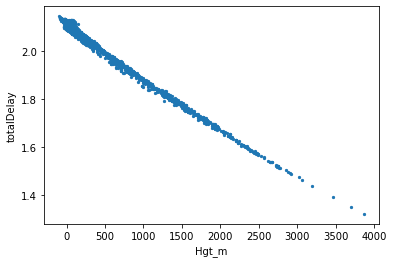

In [24]:
delays.plot.scatter(x='Hgt_m',y='totalDelay', marker='.')